In [1]:
import sys
sys.path.append("../../SiMaC/")

In [16]:
import os
import string
import time

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from src.dataset.toy import ToyDataset
from src.ml.model import SiMaC, SiMaCImplicit
from src.ml.layers import ScaledEmbedding
from src.ml.sinkhorn import SinkhornLoss, sinkhorn
from src.ml.train import assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

# Dataset

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

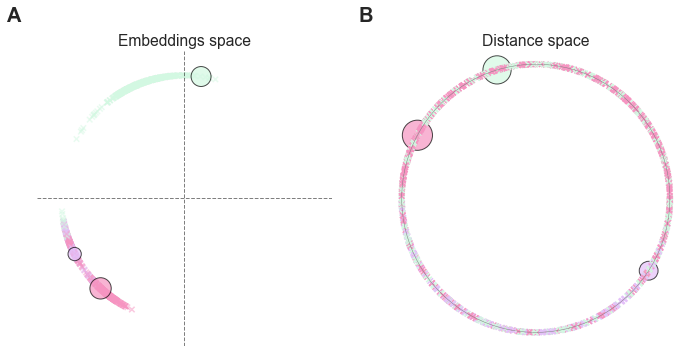

In [8]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

# Training

In [9]:
sinkhorn_n_iter = 100
sinkohrn_epsilon = 0.05
n_epochs = 200
learning_rate = 0.005

## SiMaC

In [10]:
def train_simac(toy, epsilon=sinkohrn_epsilon, n_iter=sinkhorn_n_iter):
    model = SiMaC(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=toy.users_features.shape[1],
        n_iter=n_iter,
        epsilon=epsilon,
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())
    criterion = torch.nn.NLLLoss()

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        P = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = criterion(torch.log(P), toy.y_true_tensor)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([epoch+1, loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [11]:
_ = train_simac(toy)

Epoch 200: loss=0.255758, F1=0.966


## SiMaC with implicit layers

In [12]:
def train_simac_implicit(toy, epsilon=sinkohrn_epsilon, n_iter=sinkhorn_n_iter):
    # define model, loss & optimizer
    model = SiMaCImplicit(
        capacities=toy.items_capacities,
        n_users=toy.n_users,
        alpha=distance_weight,
        n_features=toy.users_features.shape[1],
        user_embeddings=torch.FloatTensor(toy.users_features),
        train_user_embeddings=False
    )

    a = torch.ones(toy.n_users)
    b = torch.FloatTensor(toy.items_capacities).view(-1)

    sinkhorn_loss = SinkhornLoss(
        a=a,
        b=b,
        solver=sinkhorn,
        n_iter=n_iter,
        epsilon=epsilon
    )

    optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())
    
    target = torch.nn.functional.one_hot(
        torch.tensor(toy.assigned_item_for_user),
        num_classes=toy.n_items
    )

    #########
    # Train #
    #########

    model.train()

    stats = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_epoch_loss = 0
        optimizer.zero_grad()

        # Model out
        M = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)

        # Loss
        loss = sinkhorn_loss(M, target)
        loss.backward()
        optimizer.step()
        
        epoch_duration = 1000 * (time.time() - start_time)

        with torch.no_grad():
            P = sinkhorn(M, a, b, epsilon, n_iter)

        # Predictions
        y_pred = assign_with_lap(P, toy.items_capacities)
        f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")

        stats.append([epoch+1, loss.item(), f1, epoch_duration])

    print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    
    return stats

In [13]:
_ = train_simac_implicit(toy)

Epoch 200: loss=325.690277, F1=0.910


# Experiments

## Run multiple trainings

In [18]:
n_trainings = 20

In [19]:
print("---- Running {0} trainings of SiMaC ----".format(n_trainings))
simac_results = [train_simac(toy) for i in range(n_trainings)]

print("\n---- Running {0} trainings of SiMaC with implicit layers ----".format(n_trainings))
simac_implicit_results = [train_simac_implicit(toy) for i in range(n_trainings)]

---- Running 20 trainings of SiMaC ----
Epoch 200: loss=0.159535, F1=0.931
Epoch 200: loss=0.733686, F1=0.475
Epoch 200: loss=0.154695, F1=0.972
Epoch 200: loss=0.160804, F1=0.964
Epoch 200: loss=0.368577, F1=0.863
Epoch 200: loss=0.109702, F1=0.972
Epoch 200: loss=0.180882, F1=0.938
Epoch 200: loss=0.136762, F1=0.989
Epoch 200: loss=0.128311, F1=0.976
Epoch 200: loss=0.106659, F1=0.976
Epoch 200: loss=0.175498, F1=0.975
Epoch 200: loss=0.176577, F1=0.928
Epoch 200: loss=0.237441, F1=0.909
Epoch 200: loss=0.104276, F1=0.974
Epoch 200: loss=0.315473, F1=0.908
Epoch 200: loss=0.105903, F1=0.974
Epoch 200: loss=0.102065, F1=0.964
Epoch 200: loss=0.127616, F1=0.987
Epoch 200: loss=0.222802, F1=0.948
Epoch 200: loss=0.150536, F1=0.976

---- Running 20 trainings of SiMaC with implicit layers ----
Epoch 200: loss=156.535339, F1=0.953
Epoch 200: loss=413.414612, F1=0.831
Epoch 200: loss=116.613525, F1=0.977
Epoch 200: loss=149.417496, F1=0.986
Epoch 200: loss=475.110596, F1=0.840
Epoch 200: lo

In [20]:
assert np.asarray(simac_results).shape == (n_trainings, n_epochs, 4)
assert np.asarray(simac_implicit_results).shape == (n_trainings, n_epochs, 4)

In [22]:
results_dfs = []

for results in [simac_results, simac_implicit_results]:
    dfs = []
    
    for run_index, run_stats in enumerate(results):
        run_stats_df = pd.DataFrame(run_stats, columns=["epoch", "loss", "F1", "epoch_duration"])
        run_stats_df["run_index"] = run_index+1

        dfs.append(run_stats_df)
    df = pd.concat(dfs)
    results_dfs.append(df)
        
simac_results_df, simac_implicit_results_df = results_dfs[0], results_dfs[1]

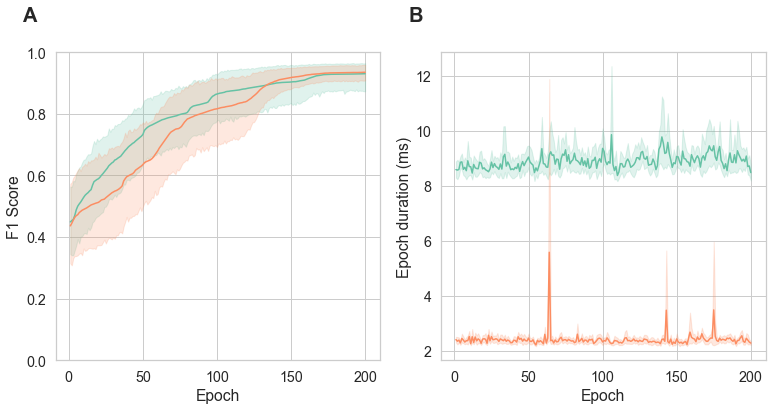

In [23]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(11, 6),
    sharex=True
)

############
# F1 score #
############

ax = axs[0]
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_ylim(0, 1)

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="F1",
    ax=ax
)

##################
# Epoch duration #
##################

ax = axs[1]
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch duration (ms)")

sns.lineplot(
    data=simac_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

sns.lineplot(
    data=simac_implicit_results_df.reset_index(),
    x="epoch",
    y="epoch_duration",
    ax=ax
)

# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Number of features

In [33]:
n_trainings = 10
n_datasets = 5

In [34]:
toy_datasets = []
n_features_to_try = [2, 8, 16, 32, 64]

for n_features_tmp in n_features_to_try:
    datasets_tmp = []
    
    for dataset_index in range(n_datasets):
        toy_tmp = ToyDataset(
            n_centers=n_centers,
            n_items=n_items,
            n_users=n_users,
            n_features=n_features_tmp,
            distance_weight=distance_weight
        )

        datasets_tmp.append(dict(toy=toy_tmp, index=dataset_index))
    
    toy_datasets.append(dict(n_features=n_features_tmp, datasets=datasets_tmp))

In [40]:
results_list = []

for features_dataset in toy_datasets:
    print("--- {0} features ----".format(features_dataset["n_features"]))
    for dataset in features_dataset["datasets"]:
        print("--- Dataset {0} ----".format(dataset["index"]+1))
        for model_name, func in [("SiMaC", train_simac), ("SiMaC (implicit)", train_simac_implicit)]:
            print("--- {0} ---".format(model_name))
            for training_index in range(n_trainings):
            
                results = func(dataset["toy"])
                df = pd.DataFrame(
                    results,
                    columns=["epoch", "loss", "F1", "epoch_duration"]
                )
                df["model"] = model_name
                df["n_features"] = features_dataset["n_features"]
                df["dataset_index"] = dataset["index"]+1
                df["training_index"] = training_index+1
                
                results_list.append(df)
    
results_df = pd.concat(results_list)

--- 2 features ----
--- Dataset 1 ----
--- SiMaC ---
Epoch 200: loss=0.087785, F1=0.928
Epoch 200: loss=0.252265, F1=0.740
Epoch 200: loss=0.136630, F1=0.923
Epoch 200: loss=0.097127, F1=0.947
Epoch 200: loss=0.082899, F1=0.920
Epoch 200: loss=0.131246, F1=0.909
Epoch 200: loss=0.160296, F1=0.867
Epoch 200: loss=0.097977, F1=0.906
Epoch 200: loss=0.229119, F1=0.760
Epoch 200: loss=0.097964, F1=0.946
--- SiMaC (implicit) ---
Epoch 200: loss=609.225647, F1=0.660
Epoch 200: loss=366.037720, F1=0.703
Epoch 200: loss=237.308258, F1=0.743
Epoch 200: loss=126.057053, F1=0.918
Epoch 200: loss=130.597443, F1=0.917
Epoch 200: loss=552.718933, F1=0.680
Epoch 200: loss=337.714996, F1=0.781
Epoch 200: loss=104.210609, F1=0.908
Epoch 200: loss=507.798065, F1=0.713
Epoch 200: loss=424.113403, F1=0.711
--- Dataset 2 ----
--- SiMaC ---
Epoch 200: loss=0.096391, F1=0.773
Epoch 200: loss=0.172067, F1=0.928
Epoch 200: loss=0.130812, F1=0.838
Epoch 200: loss=0.109682, F1=0.883
Epoch 200: loss=0.108081, F1=

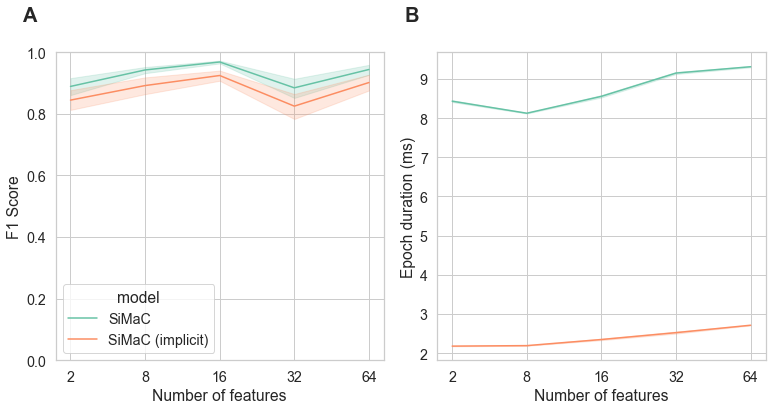

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))


# F1 score
ax = axs[0]

results_df["n_features"] = results_df["n_features"].astype(str)

sns.lineplot(
    data=results_df.loc[results_df["epoch"] == 200].reset_index(),
    x="n_features",
    y="F1",
    hue="model",
    ax=ax
)

ax.set_ylim(0, 1)
ax.set_xlabel("Number of features")
ax.set_ylabel("F1 Score")


# Epoch duration
ax = axs[1]

sns.lineplot(
    data=results_df.reset_index(),
    x="n_features",
    y="epoch_duration",
    hue="model",
    ax=ax,
    legend=False
)

ax.set_xlabel("Number of features")
ax.set_ylabel("Epoch duration (ms)")


# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Sinkhorn epsilon

In [61]:
n_trainings = 10
epsilon_to_try = [0.05, 0.1, 0.3, 0.5, 0.8, 1]

In [63]:
results_list = []

for epsilon_tmp in epsilon_to_try:
    print("--- Epsilon={0} ---".format(epsilon_tmp))
    for model_name, func in [("SiMaC", train_simac), ("SiMaC (implicit)", train_simac_implicit)]:
        print("--- {0} ---".format(model_name))
        for training_index in range(n_trainings):

            results = func(toy, epsilon=epsilon_tmp)
            df = pd.DataFrame(
                results,
                columns=["epoch", "loss", "F1", "epoch_duration"]
            )
            df["model"] = model_name
            df["epsilon"] = epsilon_tmp
            df["training_index"] = training_index+1

            results_list.append(df)

results_df = pd.concat(results_list)

--- Epsilon=0.05 ---
--- SiMaC ---
Epoch 200: loss=0.195675, F1=0.983
Epoch 200: loss=0.305353, F1=0.870
Epoch 200: loss=0.175512, F1=0.934
Epoch 200: loss=0.121499, F1=0.966
Epoch 200: loss=0.159921, F1=0.981
Epoch 200: loss=0.133017, F1=0.994
Epoch 200: loss=0.228495, F1=0.949
Epoch 200: loss=0.212856, F1=0.952
Epoch 200: loss=0.572355, F1=0.482
Epoch 200: loss=0.139870, F1=0.976
--- SiMaC (implicit) ---
Epoch 200: loss=146.535904, F1=0.986
Epoch 200: loss=293.090027, F1=0.918
Epoch 200: loss=157.525787, F1=0.983
Epoch 200: loss=259.660583, F1=0.930
Epoch 200: loss=206.476242, F1=0.963
Epoch 200: loss=193.987228, F1=0.941
Epoch 200: loss=1019.233521, F1=0.708
Epoch 200: loss=154.409348, F1=0.986
Epoch 200: loss=438.099548, F1=0.835
Epoch 200: loss=600.246338, F1=0.473
--- Epsilon=0.1 ---
--- SiMaC ---
Epoch 200: loss=0.259500, F1=0.974
Epoch 200: loss=0.267070, F1=0.926
Epoch 200: loss=0.245882, F1=0.976
Epoch 200: loss=0.225155, F1=0.969
Epoch 200: loss=0.301519, F1=0.972
Epoch 200:

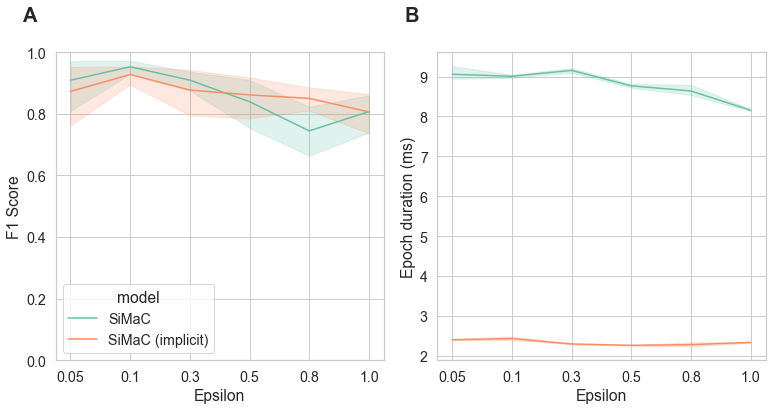

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))


# F1 score
ax = axs[0]

results_df["epsilon"] = results_df["epsilon"].astype(str)

sns.lineplot(
    data=results_df.loc[results_df["epoch"] == 200].reset_index(),
    x="epsilon",
    y="F1",
    hue="model",
    ax=ax
)

ax.set_ylim(0, 1)
ax.set_xlabel("Epsilon")
ax.set_ylabel("F1 Score")


# Epoch duration
ax = axs[1]

sns.lineplot(
    data=results_df.reset_index(),
    x="epsilon",
    y="epoch_duration",
    hue="model",
    ax=ax,
    legend=False
)

ax.set_xlabel("Epsilon")
ax.set_ylabel("Epoch duration (ms)")


# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Sinkhorn iterations

In [45]:
n_trainings = 5
n_iter_to_try = [1, 10, 25, 50, 100]

In [46]:
results_list = []

for n_iter_tmp in n_iter_to_try:
    print("--- N iter={0} ---".format(n_iter_tmp))
    for model_name, func in [("SiMaC", train_simac), ("SiMaC (implicit)", train_simac_implicit)]:
        print("--- {0} ---".format(model_name))
        for training_index in range(n_trainings):

            results = func(toy, n_iter=n_iter_tmp)
            df = pd.DataFrame(
                results,
                columns=["epoch", "loss", "F1", "epoch_duration"]
            )
            df["model"] = model_name
            df["n_iter"] = n_iter_tmp
            df["training_index"] = training_index+1

            results_list.append(df)

results_df = pd.concat(results_list)

--- N iter=1 ---
--- SiMaC ---
Epoch 200: loss=2.467875, F1=0.485
Epoch 200: loss=0.106843, F1=0.967
Epoch 200: loss=0.603031, F1=0.587
Epoch 200: loss=0.098417, F1=0.951
Epoch 200: loss=0.546979, F1=0.661
--- SiMaC (implicit) ---
Epoch 200: loss=1374.425171, F1=0.950
Epoch 200: loss=4037.505127, F1=0.450
Epoch 200: loss=4698.414062, F1=0.915
Epoch 200: loss=2943.146484, F1=0.657
Epoch 200: loss=6873.982422, F1=0.824
--- N iter=10 ---
--- SiMaC ---
Epoch 200: loss=0.133205, F1=0.946
Epoch 200: loss=0.323772, F1=0.923
Epoch 200: loss=0.248232, F1=0.918
Epoch 200: loss=0.079666, F1=0.963
Epoch 200: loss=0.099939, F1=0.953
--- SiMaC (implicit) ---
Epoch 200: loss=232.185272, F1=0.911
Epoch 200: loss=142.475433, F1=0.960
Epoch 200: loss=213.346222, F1=0.910
Epoch 200: loss=150.351868, F1=0.940
Epoch 200: loss=297.259674, F1=0.905
--- N iter=25 ---
--- SiMaC ---
Epoch 200: loss=0.162824, F1=0.961
Epoch 200: loss=0.158697, F1=0.943
Epoch 200: loss=0.123638, F1=0.931
Epoch 200: loss=0.121925,

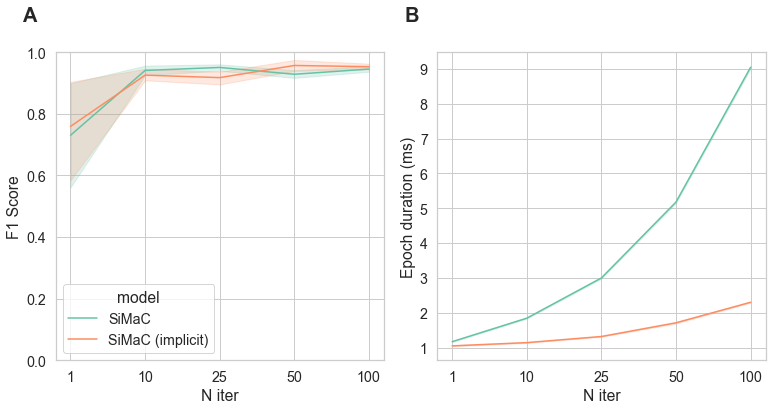

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6))


# F1 score
ax = axs[0]

results_df["n_iter"] = results_df["n_iter"].astype(str)

sns.lineplot(
    data=results_df.loc[results_df["epoch"] == 200].reset_index(),
    x="n_iter",
    y="F1",
    hue="model",
    ax=ax
)

ax.set_ylim(0, 1)
ax.set_xlabel("N iter")
ax.set_ylabel("F1 Score")


# Epoch duration
ax = axs[1]

sns.lineplot(
    data=results_df.reset_index(),
    x="n_iter",
    y="epoch_duration",
    hue="model",
    ax=ax,
    legend=False
)

ax.set_xlabel("N iter")
ax.set_ylabel("Epoch duration (ms)")


# Annotate subplots with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

# Profiling models

https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

In [58]:
print("#################\n# Regular SiMaC #\n#################")

model = SiMaC(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    alpha=distance_weight,
    n_features=toy.users_features.shape[1],
    n_iter=10,
    epsilon=.1,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)

with profile(activities=[ProfilerActivity.CPU], 
             profile_memory=True, record_shapes=True) as prof:
    model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

print("####################\n# SiMaC (implicit) #\n####################")

model = SiMaCImplicit(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    alpha=distance_weight,
    n_features=toy.users_features.shape[1],
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)

with profile(activities=[ProfilerActivity.CPU], 
             profile_memory=True, record_shapes=True) as prof:
    model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

#################
# Regular SiMaC #
#################
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
               aten::div        13.67%     107.000us        14.56%     114.000us       5.182us      62.62 Kb      62.61 Kb            22  
               aten::mul         6.51%      51.000us        10.09%      79.000us      15.800us      46.89 Kb      46.88 Kb             5  
             aten::empty         6.00%      47.000us         6.00%      47.000us       1.880us      43.10 Kb      43.10 Kb            25  
      aten::index_select         6.13%      48.000us         8.17%      64.000us      32.000us      31.25 Kb    

In [ ]:
# https://pytorch.org/docs/master/notes/cuda.html#memory-management